<a href="https://colab.research.google.com/github/DalilaR/LendingClub/blob/main/LendingClubDataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lending Club Data Exploration

The purpose of this notebook is to explore Lending Club Dataset.  In summary, lendingClub is a website where individuals can lend money to each other.  The borrowers provide information about their job history, their credit history, and a short note on their money need.  Furthermore, the borrowers with decide on the loan category (business, wedding, pay other loans, for instance).  LendingClub keeps track on who paid or not their loan after ... The dataset contains rows of borrowers, who borrowed through the lending Club site, characteristics and if they defaulted on their loan or not.  

In [ ]:
install.packages(c("caret","pROC","GGally","corrplot"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘recipes’, ‘reshape2’, ‘Rcpp’, ‘reshape’




In [ ]:
install.packages("h2o")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘RCurl’




In [ ]:
library(tidyverse)
library(caret)
library(pROC)
library(corrplot)
library(GGally)

In [ ]:
https://drive.google.com/drive/folders/1Y9e_qGZNC84BAXDqGRH0vsHPC0AFSMeF?usp=sharing

## Dataset Description

### General Desscription

Lending Club is a website that brings together individual borrowerers and landers.  The dataset has 10,000 rows, and 28 features, where the target represents wether borrowers defaulted on their payment.  Each row represents one borrower, and it has a unique id.  The other 26 features are either financial health, financial activities, work activities, or even statements from the borrowers explaining the need for the money.  The dataset contains numerical, categorical, date, and text features. 






In [ ]:
df = read_csv("Lending_Club.csv")
state_income <- read_csv("stateIncome.csv")
df <- inner_join(df,state_income)
features2keep <- setdiff(names(df),c("addr_state","Standard","State"))
df <- df[,features2keep]
summary(df)

Rows: 10000 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (12): emp_title, emp_length, home_ownership, verification_status, pymnt...
dbl  (15): Id, is_bad, annual_inc, debt_to_income, delinq_2yrs, inq_last_6mt...
date  (1): earliest_cr_line

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 51 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): State, Standard, addr_state
dbl (1): state_income

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = "addr_state"


       Id            is_bad        emp_title          emp_length       
 Min.   :    1   Min.   :0.0000   Length:10000       Length:10000      
 1st Qu.: 2501   1st Qu.:0.0000   Class :character   Class :character  
 Median : 5000   Median :0.0000   Mode  :character   Mode  :character  
 Mean   : 5000   Mean   :0.1295                                        
 3rd Qu.: 7500   3rd Qu.:0.0000                                        
 Max.   :10000   Max.   :1.0000                                        
                                                                       
 home_ownership       annual_inc     verification_status  pymnt_plan       
 Length:10000       Min.   :  2000   Length:10000        Length:10000      
 Class :character   1st Qu.: 40000   Class :character    Class :character  
 Mode  :character   Median : 58000   Mode  :character    Mode  :character  
                    Mean   : 68203                                         
                    3rd Qu.: 82000          

fix the miss-labeled features

In [ ]:
factor_list <- c("home_ownership","verification_status","pymnt_plan","purpose_cat","policy_code","initial_list_status")
df[,factor_list] <- df[,factor_list] %>% mutate_if(is.character, as.factor)
df$emp_length <- as.numeric(df$emp_length)
df$Id <- as.character(df$Id)
keepFeatures <- setdiff(names(df),c("zip_code"))



Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


## Split dataset into training and testing data sets, and perform initial cleaning


1.   Split dataset into training and testing sets
2.   Remove near zero features
3.   Remove features with more than 40% missing values
4.   Perform Exploratory Data Analysis






In [ ]:
trainNDX <- createDataPartition(df$is_bad,p=0.8,list = FALSE, times = 1)

In [ ]:

train_data <- df[trainNDX,]
test_data <- df[-trainNDX,]

NZ <- nearZeroVar(train_data)
train_data <- train_data[,-NZ]

text_features <- c("purpose","Notes","emp_title")
#Remove Zipcode as it is we already have states
features2keep <- setdiff(names(train_data) ,c("zip_code","id"))
train_data <- train_data[,features2keep]
pct_na <- function (val){
  result <- sum(ifelse(is.na(val),1,0))
  result <- result/length(val)
  return (result)
}
#Remove feature with over 40% missing values
percent_na <- train_data %>% summarize_all(list(count_na= pct_na))
percent_na <- t(percent_na)
highPctMissingValues <- which(percent_na > 0.4)
percent_na


Id_count_na,0.000000
is_bad_count_na,0.000000
emp_title_count_na,0.057375
emp_length_count_na,0.024125
home_ownership_count_na,0.000000
annual_inc_count_na,0.000125
verification_status_count_na,0.000000
Notes_count_na,0.322750
purpose_cat_count_na,0.000000
purpose_count_na,0.000375
debt_to_income_count_na,0.000000


In [ ]:
features2keep <- names(train_data)[-highPctMissingValues]
train_data <- train_data[,features2keep]
num_cols <- unlist(lapply(train_data, is.numeric)) 
train_data$is_bad <- factor(train_data$is_bad)
summary(train_data)

      Id            is_bad    emp_title           emp_length    
 Length:8000        0:6952   Length:8000        Min.   : 1.000  
 Class :character   1:1048   Class :character   1st Qu.: 2.000  
 Mode  :character            Mode  :character   Median : 4.000  
                                                Mean   : 4.974  
                                                3rd Qu.: 9.000  
                                                Max.   :33.000  
                                                NA's   :193     
  home_ownership   annual_inc                   verification_status
 MORTGAGE:3538   Min.   :  2000   not verified            :3478    
 NONE    :   1   1st Qu.: 40000   VERIFIED - income       :2558    
 OTHER   :  28   Median : 58216   VERIFIED - income source:1964    
 OWN     : 612   Mean   : 68080                                    
 RENT    :3821   3rd Qu.: 82000                                    
                 Max.   :900000                                    
    

In [ ]:
summary(train_data)

      Id            is_bad    emp_title           emp_length    
 Length:8000        0:6952   Length:8000        Min.   : 1.000  
 Class :character   1:1048   Class :character   1st Qu.: 2.000  
 Mode  :character            Mode  :character   Median : 4.000  
                                                Mean   : 4.974  
                                                3rd Qu.: 9.000  
                                                Max.   :33.000  
                                                NA's   :193     
  home_ownership   annual_inc                   verification_status
 MORTGAGE:3538   Min.   :  2000   not verified            :3478    
 NONE    :   1   1st Qu.: 40000   VERIFIED - income       :2558    
 OTHER   :  28   Median : 58216   VERIFIED - income source:1964    
 OWN     : 612   Mean   : 68080                                    
 RENT    :3821   3rd Qu.: 82000                                    
                 Max.   :900000                                    
    

Check the location of NA

In [ ]:
train_data[c("total_acc","delinq_2yrs","inq_last_6mths","earliest_cr_line")] %>% filter(is.na(earliest_cr_line ))

total_acc,delinq_2yrs,inq_last_6mths,earliest_cr_line
<dbl>,<dbl>,<dbl>,<date>
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA


Plot a matrix scatterplot to check for colinearity and features distribution. 


*   Annual_income, delinq_2yr, pub_rec, revol_balance, total_acc, last_6mth highly skewed (large number of outliers)
*   All outliers in emp_length map to not default (is_bad equal to 0)
*   The extreme outliers in revol_balance, and last_6mth, and even income_balance map to is_bad equal 0)
*   List item





`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


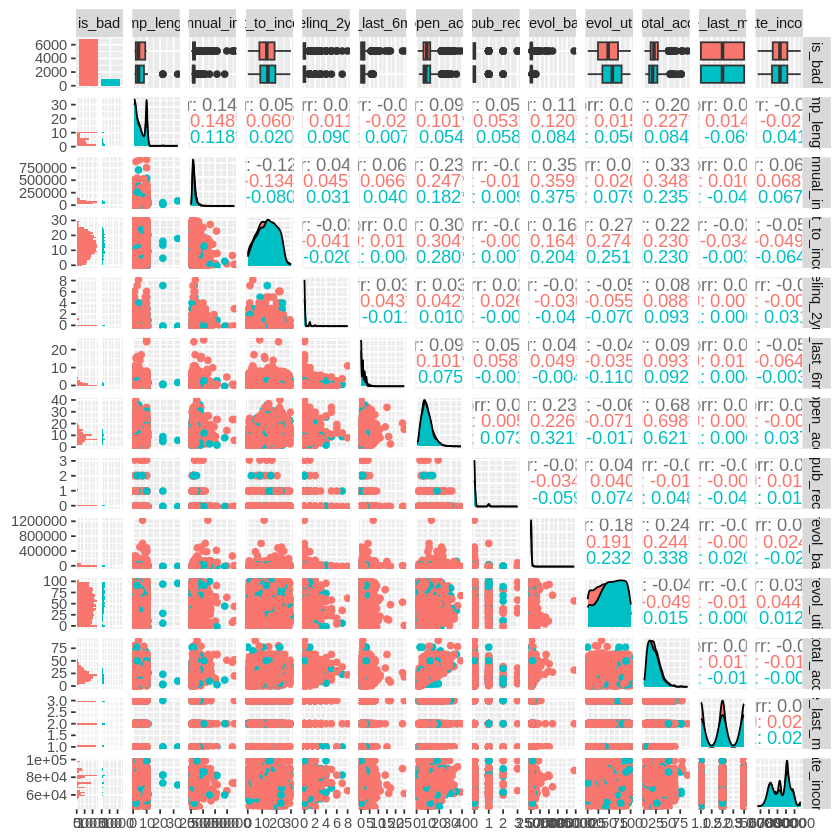

In [ ]:
tmp_df <- na.omit(train_data[,num_cols])
ggpairs(tmp_df, aes(colour = is_bad), lower=list(combo=wrap("facethist"),
upper = list(continuous = wrap("cor", size = 6))))

***Checking for Colinearity Issues***

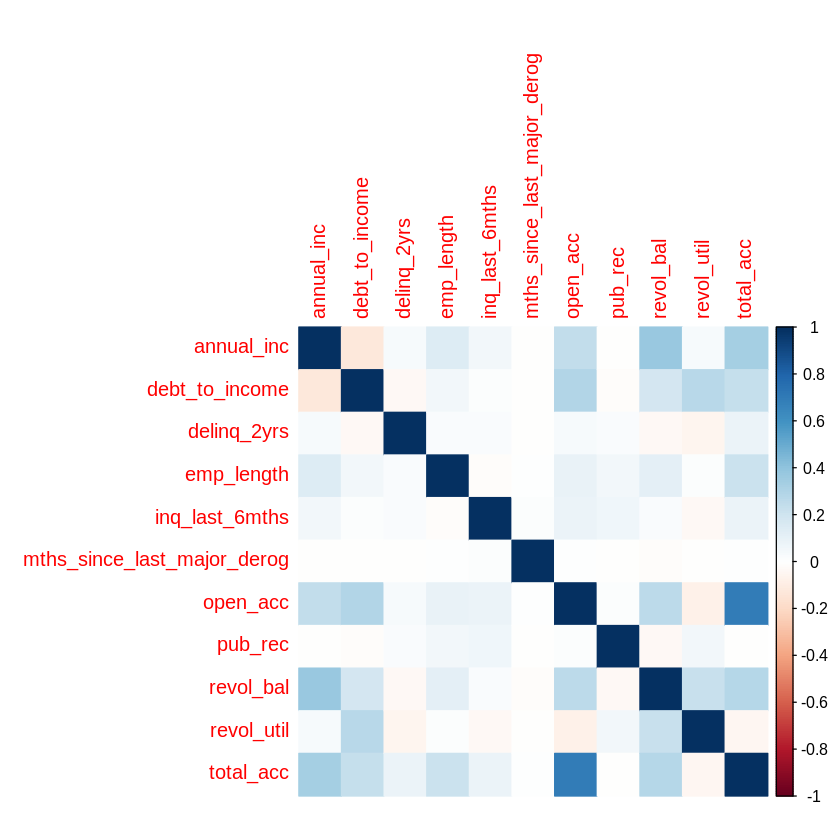

In [ ]:
numcols <- names(train_data)[num_cols]
tmp_df <- na.omit(train_data[,numcols[3:length(numcols)]])
train_cor = cor(tmp_df)
corrplot(train_cor,method="color",order="alphabet")
#Confirm no colinearity


**Note** We noticed if **earliest_cr_line** is NA, all other numeric features are also NA.  We are 2 options to deal with this:  remove the rows, or impute them with zero.  As it means that the borrower is new at borrowing so has no credit history.

For other features with NA values, we just impute them with median. 

**Observations**


*   Comparing the means and medians one can see that annual_inc, revol_bal, balance_open_acc, and income_balance there is a big discripancy between their mean and median.  This implies highly skewed distributions. 

*   Most have extreme outliers 





In [ ]:

train_data$total_acc[is.na(train_data$earliest_cr_line)] <- 0
train_data$revol_util[is.na(train_data$earliest_cr_line)] <- 0
train_data$pub_rec[is.na(train_data$earliest_cr_line)] <- 0
train_data$open_acc[is.na(train_data$earliest_cr_line)]<- 0
train_data$inq_last_6mths[is.na(train_data$earliest_cr_line)]<- 0
train_data$delinq_2yrs[is.na(train_data$earliest_cr_line)]<- 0
train_data$mths_since_last_major_derog <- factor(train_data$mths_since_last_major_derog)

num_cols <- unlist(lapply(train_data, is.numeric))

num_impute <- preProcess(train_data[,num_cols],method = ("medianImpute"))
train_data[,num_cols] = predict(num_impute, train_data[,num_cols])
train_data$balance_open_acc  <- ifelse(train_data$open_acc >0, train_data$revol_bal / train_data$open_acc,0)
train_data$income_balance <-  ifelse(train_data$revol_bal >0, train_data$annual_inc / train_data$revol_bal,0)
train_data$open_total <-  ifelse(train_data$total_acc > 0, train_data$open_acc/ train_data$total_acc,0)
train_data$pub_rec <- as.factor(train_data$pub_rec)
num_cols <- unlist(lapply(train_data, is.numeric))
summary(train_data[,num_cols])

   emp_length       annual_inc     debt_to_income   delinq_2yrs    
 Min.   : 1.000   Min.   :  2000   Min.   : 0.00   Min.   :0.0000  
 1st Qu.: 2.000   1st Qu.: 40000   1st Qu.: 8.11   1st Qu.:0.0000  
 Median : 4.000   Median : 58216   Median :13.35   Median :0.0000  
 Mean   : 4.951   Mean   : 68079   Mean   :13.28   Mean   :0.1441  
 3rd Qu.: 9.000   3rd Qu.: 82000   3rd Qu.:18.64   3rd Qu.:0.0000  
 Max.   :33.000   Max.   :900000   Max.   :29.99   Max.   :8.0000  
 inq_last_6mths      open_acc        revol_bal         revol_util    
 Min.   : 0.000   Min.   : 0.000   Min.   :      0   Min.   :  0.00  
 1st Qu.: 0.000   1st Qu.: 6.000   1st Qu.:   3473   1st Qu.: 24.98  
 Median : 1.000   Median : 9.000   Median :   8619   Median : 48.90  
 Mean   : 1.053   Mean   : 9.313   Mean   :  14283   Mean   : 48.43  
 3rd Qu.: 2.000   3rd Qu.:12.000   3rd Qu.:  16774   3rd Qu.: 71.80  
 Max.   :25.000   Max.   :39.000   Max.   :1207359   Max.   :100.60  
   total_acc      state_income   b

Save object to impute numeric features

In [ ]:
saveRDS(num_impute,"impute_number.rds")

**Observation**  *pub_rec* has low cardinality, as seen below. What is interesting is that a pub_rec = 3 (extremely low frequency) map only to loans that didn't default.

In [ ]:
table(train_data$pub_rec[train_data$is_bad == 1])
table(train_data$pub_rec[train_data$is_bad == 0])


  0   1   2 
965  79   4 


   0    1    2    3 
6578  355   11    5 

In [ ]:
summary(train_data)

      Id            is_bad    emp_title           emp_length    
 Length:8000        0:6963   Length:8000        Min.   : 1.000  
 Class :character   1:1037   Class :character   1st Qu.: 2.000  
 Mode  :character            Mode  :character   Median : 4.000  
                                                Mean   : 4.989  
                                                3rd Qu.: 9.000  
                                                Max.   :33.000  
                                                NA's   :208     
  home_ownership   annual_inc                   verification_status
 MORTGAGE:3552   Min.   :  2000   not verified            :3490    
 NONE    :   1   1st Qu.: 40000   VERIFIED - income       :2591    
 OTHER   :  32   Median : 58000   VERIFIED - income source:1919    
 OWN     : 626   Mean   : 68290                                    
 RENT    :3789   3rd Qu.: 82000                                    
                 Max.   :900000                                    
    

## Clean earliest_cr_line

***earliest_cr_line*** is the date one has a credit line (first open credit line) 
*   Change text date to date
*   Calculate how long in years one had a credit line 

We will change impute and scale and center later




In [ ]:

train_data$earliest_cr_line <- as.Date(train_data$earliest_cr_line,format= "%Y-%m-%d")
max_date <- max(train_data$earliest_cr_line,na.rm = TRUE)
max_date

[1] "2008-11-01"

In [ ]:

train_data$years_of_cr_line <-  ifelse(!is.na(train_data$earliest_cr_line),as.double(difftime(max_date ,train_data$earliest_cr_line,units= "days"))/365,NA_real_)

train_data$years_of_cr_line[(train_data$years_of_cr_line > 0) & (train_data$years_of_cr_line < 1)] <- 1


In [ ]:
summary(train_data$years_of_cr_line)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    7.09   10.35   11.62   14.84   57.96       3 

One can see that as expected, if you just opened an account then of course you cannot have a bad loan.  What is interesting is that 





*   See if you can collapse some numeric features to lower cardinality


Explore the relationship between some numerical features and target is_bad through boxplot


Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


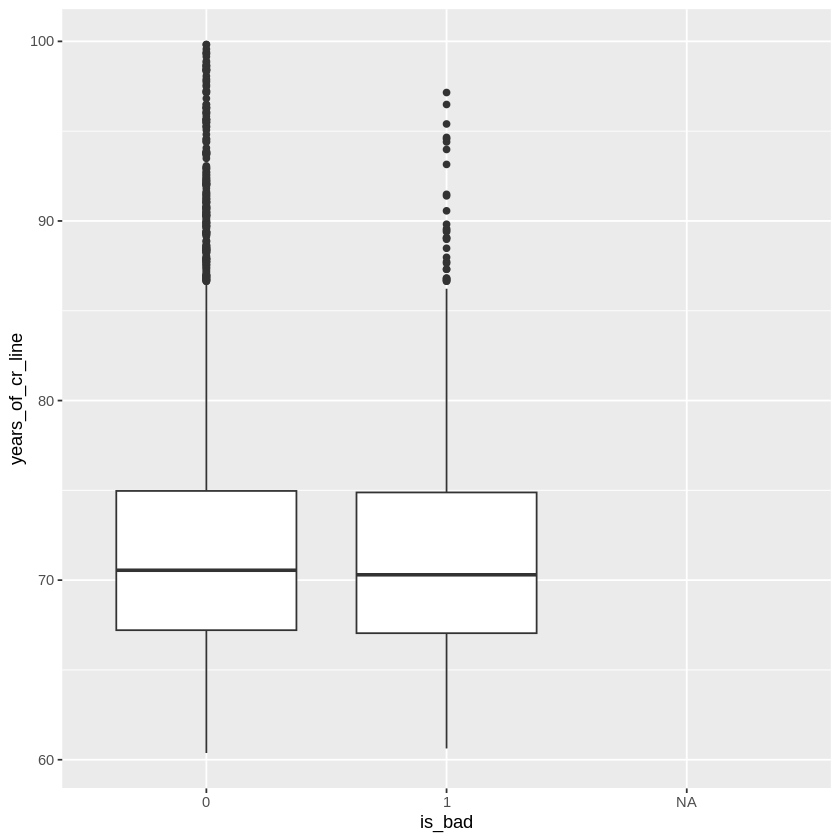

In [ ]:
ggplot(train_data[train_data$years_of_cr_line >50,], aes(is_bad,years_of_cr_line)) + geom_boxplot()

One can see, if inq_last_6mths is larger than 7, than the borrowers doesn't default

Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


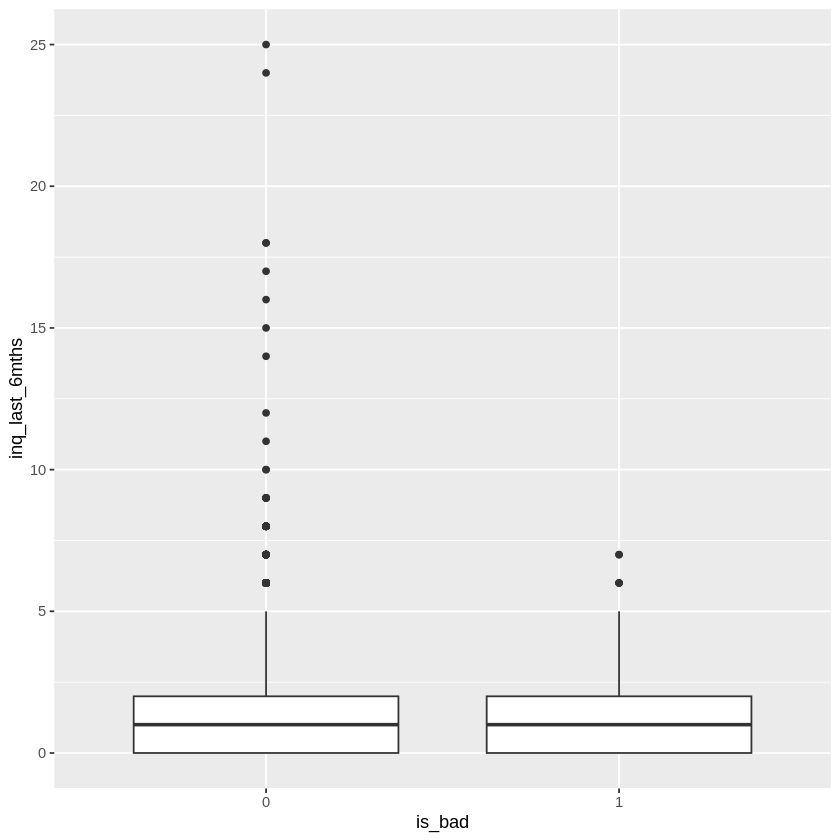

In [ ]:
ggplot(train_data,aes(is_bad,inq_last_6mths))+geom_boxplot()

**Note**  From the summary statistics, we noticed that some features appear to have low cardinality.  The question is can we change these features to categorical features, and can we combine some of these values?

We see below, that beyond inq_last_6mths of 8 and beyond, the target *is_bad* is equal to 0, or no borrowers defaulted on their loans.
We also notice that the frequency of number of inq_last_6mths distribution looks like a Pareto Distribution, or Zepl one.

In [ ]:
table(train_data$is_bad, train_data$inq_last_6mths)
quantile(train_data$inq_last_6mths,probs = 0.99,na.rm=TRUE)

   
       0    1    2    3    4    5    6    7    8    9   10   11   14   15   16
  0 3281 1852  944  453  171  123   58   31   21    5    2    2    1    1    1
  1  436  299  182  111    9    4    4    3    0    0    0    0    0    0    0
   
      17   24   25
  0    1    1    1
  1    0    0    0

99% 
  6

For comparing open_acc and is_bad, we notice: 

*   Very few borrowers have 24 or more open_acc.
*   99% of borrowers have 23 or less open_acc.

We can clip the feature values to 23




In [ ]:
table(train_data$is_bad, train_data$open_acc)
quantile(train_data$open_acc,probs = 0.99,na.rm=TRUE)

   
      1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  0   5 100 252 446 529 706 713 645 647 547 487 414 318 242 222 155 132  92  82
  1   0  26  55  66  76  94 109  95  95  87  77  51  59  32  22  13  18  14  12
   
     20  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  39
  0  57  54  29  28  13  15   6   5   5   4   4   2   1   3   0   2   1
  1   7   7   4   1   1   4   0   2   1   0   2   1   0   0   1   0   0

99% 
 23

**Observation** Borrowers with 1 and 10 years work history are the most prevalent borrowers in the dataset.  
Very few borrowers with over 10 years are in the dataset, but also the one that are in the dataset all defaulted on their loan.

In [ ]:
table(train_data$is_bad, train_data$emp_length)
quantile(train_data$emp_length,probs = 0.99,na.rm=TRUE)


   
       1    2    3    4    5    6    7    8    9   10   11   22   33
  0 1434  806  702  612  539  377  291  254  235 1551    0    0    0
  1  246  135   98   82   78   55   43   24   27  205    2    5    1

99% 
 10

**Observation**  Most borrowers didn't have delinquancy in the last 2 years. Still, some borrowers had 3 or more delinq_2yrs 

In [ ]:
table(train_data$is_bad, train_data$delinq_2yrs)
quantile(train_data$delinq_2yrs,probs = 0.99,na.rm=TRUE)

   
       0    1    2    3    4    5    6    7    8
  0 6225  559  119   27    9    5    3    1    1
  1  921   91   26    6    2    1    0    1    0

99% 
  2

In [ ]:
tp <- train_data[,c("delinq_2yrs","is_bad")] %>% group_by(delinq_2yrs) %>% 
  summarize(n_count_1= sum(ifelse(is_bad == 1,1,0)),n_count_0= sum(ifelse(is_bad == 1,0,1)))

In [ ]:
tp$ratio_1 <- tp$n_count_1/tp$n_count_0
tp$percentage <- (tp$n_count_0+tp$n_count_1)/sum(tp[,c("n_count_1","n_count_0")])
tp

delinq_2yrs,n_count_1,n_count_0,ratio_1,percentage
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,921,6228,0.1478805,0.893625
1,91,559,0.1627907,0.081250
2,26,119,0.2184874,0.018125
3,6,27,0.2222222,0.004125
4,2,9,0.2222222,0.001375
5,1,5,0.2000000,0.000750
6,0,3,0.0000000,0.000375
7,1,1,1.0000000,0.000250
8,0,1,0.0000000,0.000125


In [ ]:
table(train_data$is_bad, train_data$mths_since_last_major_derog)

   
       1    2    3
  0 2311 2407 2234
  1  318  369  361

## Clip some features, and change them to categorical features##

From the previous analysis, we noticed that we can clip some features maximum to their 99-percentile.  We can also decide to change them to categorical features.  The advantage of putting them into categorical features, may not add an advantage to tree based models, which already tend to have heuristic approach to split numerical features.
While not shown here, we found out that by changing these features to categorical features, we improved the performance of most our models.

In [ ]:
train_data$emp_length <- ifelse(train_data$emp_length>= 11,11, train_data$emp_length)
train_data$open_acc <- ifelse(train_data$open_acc >= 23, 23,train_data$open_acc)
train_data$inq_last_6mths <- ifelse(train_data$inq_last_6mths >= 4, 4,train_data$inq_last_6mths)
train_data$delinq_2yrs <- ifelse(train_data$delinq_2yrs >= 3, 3,train_data$delinq_2yrs)

In [ ]:
to_factor <- c("emp_length","open_acc","inq_last_6mths","delinq_2yrs","mths_since_last_major_derog")
train_data[,to_factor] <- lapply(train_data[to_factor], as.factor) 

In [ ]:
summary(train_data)

      Id            is_bad    emp_title           emp_length    home_ownership
 Length:8000        0:6952   Length:8000        10     :1742   MORTGAGE:3538  
 Class :character   1:1048   Class :character   1      :1697   NONE    :   1  
 Mode  :character            Mode  :character   2      : 943   OTHER   :  28  
                                                4      : 892   OWN     : 612  
                                                3      : 810   RENT    :3821  
                                                5      : 625                  
                                                (Other):1291                  
   annual_inc                   verification_status    Notes          
 Min.   :  2000   not verified            :3478     Length:8000       
 1st Qu.: 40000   VERIFIED - income       :2558     Class :character  
 Median : 58216   VERIFIED - income source:1964     Mode  :character  
 Mean   : 68079                                                       
 3rd Qu.: 820

## Text Features

Catboost can deal with text features, but all other ML models require one to modify the text features to some numerical format (text embedding).  We will deal with Note, later.

1.   Don't bother with Employee Title
2.   Note: get length of the note, have a new feature for note or not note
3.   purpose: remove as it is represented by purpose_cat

One notices, that many notes start with "Borrower added on data >" .  Thus this will be removed from Note_na



In [ ]:
train_data$Notes_na <- ifelse(is.na(train_data$Notes),1,0)
train_data$Note_na <- str_replace(train_data$Notes,"Borrower added on \\d{2}/\\d{2}/\\d{2} >","")


In [ ]:
train_data$Note_length <- str_length(train_data$Notes)
train_data$Note_length[is.na(train_data$Note_length)] <- 0

## Categorical Features


*   home_ownership is mostly mortgate, or rent
*   Explore purpose_cat and see if we can consolidate some groups



In [ ]:
factor_cols <- unlist(lapply(train_data, is.factor)) 
summary(train_data[factor_cols])

 is_bad     emp_length    home_ownership               verification_status
 0:6952   10     :1742   MORTGAGE:3538   not verified            :3478    
 1:1048   1      :1697   NONE    :   1   VERIFIED - income       :2558    
          2      : 943   OTHER   :  28   VERIFIED - income source:1964    
          4      : 892   OWN     : 612                                    
          3      : 810   RENT    :3821                                    
          5      : 625                                                    
          (Other):1291                                                    
             purpose_cat   delinq_2yrs inq_last_6mths    open_acc    pub_rec 
 debt consolidation:3550   0:7149      0:3720         7      : 827   0:7546  
 credit card       :1037   1: 650      1:2151         6      : 794   1: 434  
 other             : 811   2: 145      2:1126         8      : 762   2:  15  
 home improvement  : 647   3:  56      3: 564         9      : 746   3:   5  
 major pur

Very interesting to see there is only one NONE and it has 0.  This can be removed

In [ ]:
table(train_data$home_ownership,train_data$is_bad)
train_data <- train_data[train_data$home_ownership != "NONE",]
train_data$home_ownership <- droplevels(train_data$home_ownership)

          
              0    1
  MORTGAGE 3122  416
  NONE        1    0
  OTHER      25    3
  OWN       522   90
  RENT     3282  539

In [ ]:
install.packages("wordcloud")
install.packages("RColorBrewer")
library(RColorBrewer)
library(wordcloud)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



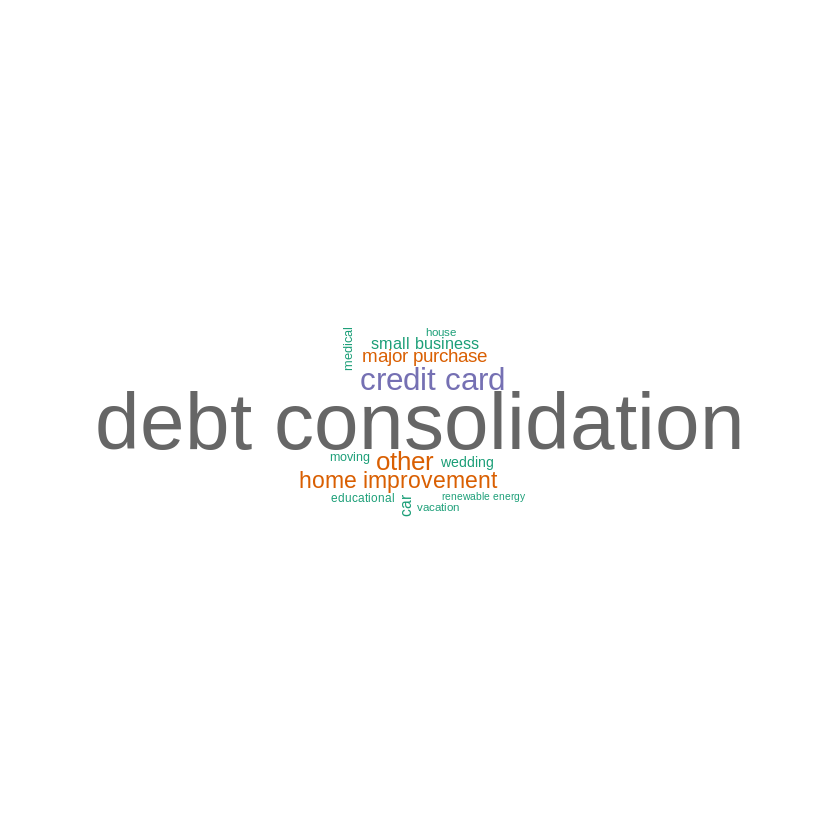

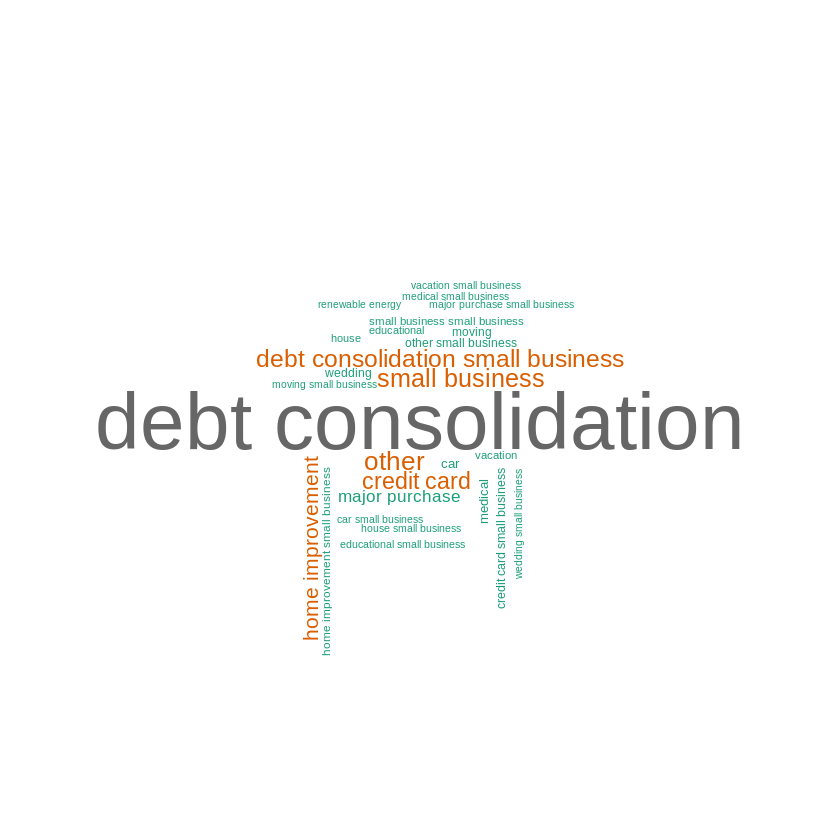

In [ ]:
purpose_freq0 <- data.frame(table(train_data$purpose_cat[train_data$is_bad == 0]))
wordcloud(words = purpose_freq0$Var1,freq = purpose_freq0$Freq, min.freq = 1,
max.words = 50, random.order=FALSE,  colors=brewer.pal(8,"Dark2"))

purpose_freq1 <- data.frame(table(train_data$purpose_cat[train_data$is_bad == 1]))
wordcloud(words = purpose_freq1$Var1,freq = purpose_freq1$Freq, min.freq = 1,
max.words = 50, random.order=FALSE,  colors=brewer.pal(8,"Dark2"))

### How are the categories (classes) within purpose_cat distributed given someone defaulted or no?

In [ ]:
names(purpose_freq1)<- c("cat","count_1")
names(purpose_freq0)<- c("cat","count_0")
purpose_table <- inner_join(purpose_freq0,purpose_freq1)

Joining, by = "cat"


We see that some categories result in 100% time of having default.  We can try to consolidate purpose_cat to at most 3 categories.
small business et_at, small business, and others

In [ ]:
purpose_table$coef <- ifelse(purpose_table$count_0 == 0, 1, 
  ifelse(purpose_table$count_1 == 0,-1,
  purpose_table$count_1/purpose_table$count_0))
purpose_table %>% arrange(coef)

cat,count_0,count_1,coef
<fct>,<int>,<int>,<dbl>
wedding,185,13,0.07027027
educational,83,6,0.07228916
car,252,20,0.07936508
credit card,957,80,0.08359457
house,69,6,0.08695652
moving,112,12,0.10714286
major purchase,392,43,0.10969388
home improvement,580,67,0.11551724
vacation,69,8,0.11594203


Create a new feature from purpose_cat that collapses the 27 levels to 5 levels

In [ ]:
purpose_freq0 <- data.frame(table(train_data$purpose_cat[train_data$is_bad == 0]))
purpose_freq1 <- data.frame(table(train_data$purpose_cat[train_data$is_bad == 1]))
names(purpose_freq1)<- c("cat","count_1")
names(purpose_freq0)<- c("cat","count_0")
purpose_table <- inner_join(purpose_freq0,purpose_freq1)

purpose_table$coef <- ifelse(purpose_table$count_0 == 0, 1, 
                             ifelse(purpose_table$count_1 == 0,-1,
                                    purpose_table$count_1/purpose_table$count_0))
purpose_table$new_cat[ purpose_table$coef == 1] <- "small business sub_cat"
purpose_table$new_cat[purpose_table$cat == "debt consolidation"] <- "debt consolidation"
purpose_table$new_cat[purpose_table$cat == "small business"] <- "small business"
other <- c("other","home improvement","medical","vacation","moving","major purchase","credit card")
purpose_table$new_cat[purpose_table$cat %in% other] <- "individual major expenses"
purpose_table$new_cat[is.na(purpose_table$new_cat)] <- "other"
write_csv(purpose_table,"purpose_lookup_table.csv")
purpose_table <- purpose_table %>% column_to_rownames(., var = "cat")
train_data$purpose_cat_clean <- purpose_table$new_cat[train_data$purpose_cat]

Joining, by = "cat"


In [ ]:
purpose_table %>% arrange(desc(count_0))

,count_0,count_1,coef,new_cat
,<int>,<int>,<dbl>,<chr>
debt consolidation,3126,424,0.13563660,debt consolidation
credit card,957,80,0.08359457,individual major expenses
other,712,98,0.13764045,individual major expenses
home improvement,580,67,0.11551724,individual major expenses
major purchase,392,43,0.10969388,individual major expenses
small business,277,92,0.33212996,small business
car,252,20,0.07936508,other
wedding,185,13,0.07027027,other
medical,124,19,0.15322581,individual major expenses


Result of collapsing 27 levels to 5 levels

In [ ]:
table(train_data$purpose_cat_clean)


       debt consolidation individual major expenses                     other 
                     3550                      3273                       649 
           small business    small business sub_cat 
                      369                       158 

One notices that we still have large outliers.  They can be an issue for linear models, or models that are sensitive to outliers like NN.  We will use quantile to identify any value that is beyond 97.5%, and collapse them to that value

In [ ]:
summary(train_data)

      Id            is_bad    emp_title           emp_length    home_ownership
 Length:7999        0:6951   Length:7999        10     :1742   MORTGAGE:3538  
 Class :character   1:1048   Class :character   1      :1696   OTHER   :  28  
 Mode  :character            Mode  :character   2      : 943   OWN     : 612  
                                                4      : 892   RENT    :3821  
                                                3      : 810                  
                                                5      : 625                  
                                                (Other):1291                  
   annual_inc                   verification_status    Notes          
 Min.   :  2000   not verified            :3477     Length:7999       
 1st Qu.: 40000   VERIFIED - income       :2558     Class :character  
 Median : 58216   VERIFIED - income source:1964     Mode  :character  
 Mean   : 68080                                                       
 3rd Qu.: 820

Remove uneccessary features, and make sure to set purpose_cat_clean to a categorical feature

In [ ]:
features4training <- setdiff(names(train_data),c("Id","Notes","purpose","earliest_cr_line","Note_na","purpose_cat"))
train_data$purpose_cat_clean <- as.factor(train_data$purpose_cat_clean)

In [ ]:
num_cols <-  unlist(lapply(train_data, is.numeric))

In [ ]:
nums <- names(train_data)[num_cols]
str(train_data)

tibble [7,999 × 30] (S3: tbl_df/tbl/data.frame)
 $ Id                         : chr [1:7999] "6" "7" "8" "9" ...
 $ is_bad                     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ emp_title                  : chr [1:7999] "BAE Systems" "Peninsula Counseling Center" "Health Plan of Nevada" "John Deere" ...
 $ emp_length                 : Factor w/ 11 levels "1","2","3","4",..: 4 10 6 2 1 3 5 1 10 1 ...
 $ home_ownership             : Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 1 1 1 4 4 4 4 1 4 ...
 $ annual_inc                 : num [1:7999] 47028 126000 42000 50000 40000 ...
 $ verification_status        : Factor w/ 3 levels "not verified",..: 2 1 3 2 1 3 1 2 2 3 ...
 $ Notes                      : chr [1:7999] NA "Borrower added on 05/18/10 > mick credit card consolidation loan - 100% payoff of credit card debt - amex, sear"| __truncated__ "Borrower added on 11/29/11 > Loan is for debt consolidation and will be paid timely.  Employed in the healthcar"| __truncated

Write a function to clip outliers or a numeric feature to its 97.5 percentile

In [ ]:
check_and_collapse_outliers <- function(val){
  qt = quantile(val,probs = 0.975,na.rm= TRUE)
  pos <- which(val > qt)
  result <- val
  result[pos] <- qt
  return (result)
}

In [ ]:
nums

[1] "emp_length"        "annual_inc"        "debt_to_income"   
 [4] "delinq_2yrs"       "inq_last_6mths"    "open_acc"         
 [7] "revol_bal"         "revol_util"        "total_acc"        
[10] "state_income"      "balance_total_acc" "balance_open_acc" 
[13] "income_balance"    "open_total"        "years_of_cr_line" 
[16] "Notes_na"          "Note_length"

In [ ]:
train_data[,nums] <- apply(train_data[,nums],2, check_and_collapse_outliers)

Impute years_of_cr_line, which is the number of years since opening a credit line.

In [ ]:
impute_year <- preProcess(train_data[,c("years_of_cr_line")],method = c("medianImpute"))
train_data[,c("years_of_cr_line")] <- predict(impute_year, train_data[,c("years_of_cr_line")])



      Id            is_bad    emp_title           emp_length    home_ownership
 Length:8000        0:6964   Length:8000        10     :1702   MORTGAGE:3558  
 Class :character   1:1036   Class :character   1      :1663   OTHER   :  26  
 Mode  :character            Mode  :character   2      : 959   OWN     : 615  
                                                4      : 921   RENT    :3801  
                                                3      : 802                  
                                                5      : 621                  
                                                (Other):1332                  
   annual_inc                   verification_status    Notes          
 Min.   :  2000   not verified            :3479     Length:8000       
 1st Qu.: 40000   VERIFIED - income       :2561     Class :character  
 Median : 58238   VERIFIED - income source:1960     Mode  :character  
 Mean   : 65960                                                       
 3rd Qu.: 820

Save the object to be used during production

In [ ]:
saveRDS(impute_year,file= "impute_year.rds")

In [ ]:
summary(train_data)

      Id            is_bad    emp_title           emp_length    home_ownership
 Length:7999        0:6951   Length:7999        10     :1742   MORTGAGE:3538  
 Class :character   1:1048   Class :character   1      :1696   OTHER   :  28  
 Mode  :character            Mode  :character   2      : 943   OWN     : 612  
                                                3      : 810   RENT    :3821  
                                                4      : 699                  
                                                (Other):1916                  
                                                NA's   : 193                  
   annual_inc                   verification_status    Notes          
 Min.   :  2000   not verified            :3477     Length:7999       
 1st Qu.: 40000   VERIFIED - income       :2558     Class :character  
 Median : 58216   VERIFIED - income source:1964     Mode  :character  
 Mean   : 65963                                                       
 3rd Qu.: 820

In [ ]:
feature4training <- setdiff(names(train_data),c("purpose","Notes","Note_na","emp_title","Id","earliest_cr_line"))

Take the log of revol_bal,state_income, balance_open_acc


In [ ]:
train_data$revol_bal <- log(train_data$revol_bal+1)
train_data$state_income <- log(train_data$state_income)
train_data$balance_open_acc <- log(train_data$balance_open_acc+1)

In [ ]:
summary(train_data)

      Id            is_bad    emp_title           emp_length    home_ownership
 Length:7999        0:6951   Length:7999        10     :1742   MORTGAGE:3538  
 Class :character   1:1048   Class :character   1      :1696   OTHER   :  28  
 Mode  :character            Mode  :character   2      : 943   OWN     : 612  
                                                4      : 892   RENT    :3821  
                                                3      : 810                  
                                                5      : 625                  
                                                (Other):1291                  
   annual_inc                   verification_status    Notes          
 Min.   :  2000   not verified            :3477     Length:7999       
 1st Qu.: 40000   VERIFIED - income       :2558     Class :character  
 Median : 58216   VERIFIED - income source:1964     Mode  :character  
 Mean   : 65963                                                       
 3rd Qu.: 820

In [ ]:
train_data$balance_open_acc[is.infinite(train_data$balance_open_acc)] <- 0
train_data$balance_open_acc[train_data$balance_open_acc < 0 ] <- 0

In [ ]:
summary(train_data)

      Id            is_bad    emp_title           emp_length    home_ownership
 Length:8000        0:6964   Length:8000        10     :1702   MORTGAGE:3558  
 Class :character   1:1036   Class :character   1      :1663   OTHER   :  26  
 Mode  :character            Mode  :character   2      : 959   OWN     : 615  
                                                4      : 921   RENT    :3801  
                                                3      : 802                  
                                                5      : 621                  
                                                (Other):1332                  
   annual_inc                   verification_status    Notes          
 Min.   :  2000   not verified            :3479     Length:8000       
 1st Qu.: 40000   VERIFIED - income       :2561     Class :character  
 Median : 58238   VERIFIED - income source:1960     Mode  :character  
 Mean   : 65960                                                       
 3rd Qu.: 820

In [ ]:
write_csv(train_data,"training_data_ready.csv")

In [ ]:
write_csv(test_data,"test_data.csv")

In [ ]:
write_csv(purpose_table,"collapse_purpose_cat.csv")

In [ ]:
str(train_data)

tibble [8,000 × 30] (S3: tbl_df/tbl/data.frame)
 $ Id                         : chr [1:8000] "1" "2" "3" "4" ...
 $ is_bad                     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ emp_title                  : chr [1:8000] "Time Warner Cable" "Ottawa University" "Kennedy Wilson" "TOWN OF PLATTEKILL" ...
 $ emp_length                 : Factor w/ 11 levels "1","2","3","4",..: 10 1 4 10 4 6 2 3 5 1 ...
 $ home_ownership             : Factor w/ 4 levels "MORTGAGE","OTHER",..: 1 4 4 1 4 1 1 4 4 4 ...
 $ annual_inc                 : num [1:8000] 50000 39216 65000 57500 47028 ...
 $ verification_status        : Factor w/ 3 levels "not verified",..: 1 1 1 1 2 3 2 3 1 2 ...
 $ Notes                      : chr [1:8000] NA "Borrower added on 04/14/11 > I will be using this loan to pay off expenses accrued in the last six months on my"| __truncated__ NA NA ...
 $ purpose_cat                : Factor w/ 27 levels "car","car small business",..: 15 5 3 5 19 5 5 3 5 5 ...
 $ purpose 

# Model Building



*   Use ony training set to build the models.
*   Split the training set into training and validation set

While the following models performed well with the validation set, their performance was slightly better than tossing a coin when used with unseen dataset.





In [ ]:
names(train_data[,features4training])

[1] "is_bad"                      "emp_title"                  
 [3] "emp_length"                  "home_ownership"             
 [5] "annual_inc"                  "verification_status"        
 [7] "debt_to_income"              "delinq_2yrs"                
 [9] "inq_last_6mths"              "open_acc"                   
[11] "pub_rec"                     "revol_bal"                  
[13] "revol_util"                  "total_acc"                  
[15] "mths_since_last_major_derog" "policy_code"                
[17] "state_income"                "balance_open_acc"           
[19] "income_balance"              "open_total"                 
[21] "years_of_cr_line"            "purpose_cat_clean"

In [ ]:
valNDX <- createDataPartition(train_data$is_bad,p=0.9,list = FALSE, times = 1)
features4training <- setdiff(features4training,c("emp_title"))
train_set0<- train_data[valNDX,features4training]
val_set0 <- train_data[-valNDX,features4training]
train_set1<- train_data[valNDX,features4training]
val_set1 <- train_data[-valNDX,features4training]
levels(train_set1$is_bad) <- c("no","yes")
levels(val_set1$is_bad)   <- c("no","yes") 

In [ ]:
names(train_set1)

[1] "is_bad"                      "emp_length"                 
 [3] "home_ownership"              "annual_inc"                 
 [5] "verification_status"         "debt_to_income"             
 [7] "delinq_2yrs"                 "inq_last_6mths"             
 [9] "open_acc"                    "pub_rec"                    
[11] "revol_bal"                   "revol_util"                 
[13] "total_acc"                   "mths_since_last_major_derog"
[15] "policy_code"                 "state_income"               
[17] "balance_open_acc"            "income_balance"             
[19] "open_total"                  "years_of_cr_line"           
[21] "purpose_cat_clean"

In [ ]:
models <- data.frame()
control <- trainControl(method = "repeatedcv",
                        number = 5,
                        repeats = 2,
                        classProbs = TRUE,
                        verboseIter = TRUE)

control_down <- trainControl(method = "repeatedcv",
                        number = 5,
                        repeats = 2,
                        classProbs = TRUE,
                        sampling = "down",
                        verboseIter = TRUE)

In [ ]:
names(train_set1)

[1] "is_bad"                      "emp_title"                  
 [3] "emp_length"                  "home_ownership"             
 [5] "annual_inc"                  "verification_status"        
 [7] "debt_to_income"              "delinq_2yrs"                
 [9] "inq_last_6mths"              "open_acc"                   
[11] "pub_rec"                     "revol_bal"                  
[13] "revol_util"                  "total_acc"                  
[15] "mths_since_last_major_derog" "policy_code"                
[17] "state_income"                "balance_open_acc"           
[19] "income_balance"              "open_total"                 
[21] "years_of_cr_line"            "purpose_cat_clean"

In [ ]:
install.packages("MLmetrics")
library(MLmetrics)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘caTools’, ‘gplots’, ‘ROCR’



Attaching package: ‘MLmetrics’


The following object is masked from ‘package:psych’:

    AUC


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following object is masked from ‘package:base’:

    Recall




In [ ]:
install.packages("glmnet")
library(glmnet)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘RcppEigen’


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-4



In [ ]:
find_best_recall_precision <- function(target, prediction){
  threshold <- 0.05
  found_max <- FALSE
  while (! found_max){
    tmp_val <- ifelse(prediction >= threshold,"yes","no")
    
  }
}

In [ ]:
elastic_modelNoPre <- train(is_bad ~ purpose_cat_clean+emp_length+open_total+inq_last_6mths+
  open_acc,
                       data = train_set1,
                       method = "glmnet",
                       tuneLength = 8,
                       trControl = control)
EvalEN2<- predict(elastic_model,newdata=val_set1,type="prob")
roc_obj <- roc(as.factor(val_set1$is_bad),EvalEN2[,1] )
auc(roc_obj)


+ Fold1.Rep1: alpha=0.1000, lambda=0.0881 
- Fold1.Rep1: alpha=0.1000, lambda=0.0881 
+ Fold1.Rep1: alpha=0.2286, lambda=0.0881 
- Fold1.Rep1: alpha=0.2286, lambda=0.0881 
+ Fold1.Rep1: alpha=0.3571, lambda=0.0881 
- Fold1.Rep1: alpha=0.3571, lambda=0.0881 
+ Fold1.Rep1: alpha=0.4857, lambda=0.0881 
- Fold1.Rep1: alpha=0.4857, lambda=0.0881 
+ Fold1.Rep1: alpha=0.6143, lambda=0.0881 
- Fold1.Rep1: alpha=0.6143, lambda=0.0881 
+ Fold1.Rep1: alpha=0.7429, lambda=0.0881 
- Fold1.Rep1: alpha=0.7429, lambda=0.0881 
+ Fold1.Rep1: alpha=0.8714, lambda=0.0881 
- Fold1.Rep1: alpha=0.8714, lambda=0.0881 
+ Fold1.Rep1: alpha=1.0000, lambda=0.0881 
- Fold1.Rep1: alpha=1.0000, lambda=0.0881 
+ Fold2.Rep1: alpha=0.1000, lambda=0.0881 
- Fold2.Rep1: alpha=0.1000, lambda=0.0881 
+ Fold2.Rep1: alpha=0.2286, lambda=0.0881 
- Fold2.Rep1: alpha=0.2286, lambda=0.0881 
+ Fold2.Rep1: alpha=0.3571, lambda=0.0881 
- Fold2.Rep1: alpha=0.3571, lambda=0.0881 
+ Fold2.Rep1: alpha=0.4857, lambda=0.0881 
- Fold2.Rep

Setting levels: control = no, case = yes

Setting direction: controls > cases



Area under the curve: 0.6922

In [ ]:
saveRDS(elastic_modelNoPre,"best_Elastic_model_noPre.rds")

In [ ]:
val_p <- ifelse(val_set1$is_bad == "no",0,1)
LogLoss(as.numeric(EvalEN2[,1]),as.numeric(val_p))
varImp(elastic_modelNoPre)

[1] 2.000383

glmnet variable importance

  only 20 most important variables shown (out of 42)

                                            Overall
purpose_cat_cleansmall business sub_cat    100.0000
emp_length11                                75.0577
purpose_cat_cleansmall business             21.2861
open_total                                  20.2363
open_acc1                                   13.6829
inq_last_6mths4                             12.9309
purpose_cat_cleanother                       9.4964
open_acc16                                   8.7305
open_acc3                                    8.6710
inq_last_6mths3                              8.4794
open_acc2                                    6.0451
inq_last_6mths2                              5.0570
emp_length8                                  4.5159
emp_length9                                  3.7812
purpose_cat_cleanindividual major expenses   2.6260
open_acc20                                   2.4859
inq_last_6mths1                   

In [ ]:
elastic_model <- train(is_bad ~ .,
                       data = train_set1,
                       preProcess = c("scale","center"),
                       method = "glmnet",
                       tuneLength = 8,
                       trControl = control)
EvalEN<- predict(elastic_model,newdata=val_set1,type="prob")
roc_obj <- roc(as.factor(val_set1$is_bad),EvalEN[,1] )
auc(roc_obj)
LogLoss(EvalEn[,1],val_set1$is_bad)

+ Fold1.Rep1: alpha=0.1000, lambda=0.0881 
- Fold1.Rep1: alpha=0.1000, lambda=0.0881 
+ Fold1.Rep1: alpha=0.2286, lambda=0.0881 
- Fold1.Rep1: alpha=0.2286, lambda=0.0881 
+ Fold1.Rep1: alpha=0.3571, lambda=0.0881 
- Fold1.Rep1: alpha=0.3571, lambda=0.0881 
+ Fold1.Rep1: alpha=0.4857, lambda=0.0881 
- Fold1.Rep1: alpha=0.4857, lambda=0.0881 
+ Fold1.Rep1: alpha=0.6143, lambda=0.0881 
- Fold1.Rep1: alpha=0.6143, lambda=0.0881 
+ Fold1.Rep1: alpha=0.7429, lambda=0.0881 
- Fold1.Rep1: alpha=0.7429, lambda=0.0881 
+ Fold1.Rep1: alpha=0.8714, lambda=0.0881 
- Fold1.Rep1: alpha=0.8714, lambda=0.0881 
+ Fold1.Rep1: alpha=1.0000, lambda=0.0881 
- Fold1.Rep1: alpha=1.0000, lambda=0.0881 
+ Fold2.Rep1: alpha=0.1000, lambda=0.0881 
- Fold2.Rep1: alpha=0.1000, lambda=0.0881 
+ Fold2.Rep1: alpha=0.2286, lambda=0.0881 
- Fold2.Rep1: alpha=0.2286, lambda=0.0881 
+ Fold2.Rep1: alpha=0.3571, lambda=0.0881 
- Fold2.Rep1: alpha=0.3571, lambda=0.0881 
+ Fold2.Rep1: alpha=0.4857, lambda=0.0881 
- Fold2.Rep

Setting levels: control = 0, case = 1

Setting direction: controls > cases



Area under the curve: 0.6883

In [ ]:
train_initial <- df[trainNDX,]
train_set_init <- train_initial[valNDX,]
val_set_init <- train_initial[-valNDX,]

In [ ]:
featureList <- setdiff(names(train_set_init),c("Id",'emp_title','Notes','purpose','zip_code',"collections_12_mths_ex_med",'pymnt_plan',"initial_list_status","purpose_cat"))
train_set_init <- train_set_init[,featureList]
train_set_init <- na.omit(train_set_init)
summary(train_set_init[,featureList])
glm_fit <- glm(is_bad~., data= train_set_init,family= binomial())


     is_bad         emp_length      home_ownership   annual_inc    
 Min.   :0.0000   Min.   : 1.000   MORTGAGE:150    Min.   :  2000  
 1st Qu.:0.0000   1st Qu.: 1.000   NONE    :  0    1st Qu.: 37164  
 Median :0.0000   Median : 4.000   OTHER   :  0    Median : 58000  
 Mean   :0.1216   Mean   : 4.705   OWN     : 34    Mean   : 63302  
 3rd Qu.:0.0000   3rd Qu.: 8.000   RENT    :186    3rd Qu.: 79885  
 Max.   :1.0000   Max.   :22.000                   Max.   :350000  
               verification_status debt_to_income    delinq_2yrs    
 not verified            :266      Min.   : 0.000   Min.   :0.0000  
 VERIFIED - income       : 55      1st Qu.: 7.037   1st Qu.:0.0000  
 VERIFIED - income source: 49      Median :11.970   Median :0.0000  
                                   Mean   :12.442   Mean   :0.3081  
                                   3rd Qu.:17.277   3rd Qu.:0.0000  
                                   Max.   :29.600   Max.   :8.0000  
 earliest_cr_line     inq_last_6mths   mt

In [ ]:
val_set_init <- val_set_init[,featureList]
val_set_init <- na.omit(val_set_init)


In [ ]:
pred <- predict(glm_fit, val_set_init, type="response")

In [ ]:
roc_obj <- roc(as.factor(val_set_init$is_bad),pred )
auc(roc_obj)
LogLoss(pred,val_set_init$is_bad)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.615

[1] 0.3646765

In [ ]:
names(train_initial)

[1] "Id"                          "is_bad"                     
 [3] "emp_title"                   "emp_length"                 
 [5] "home_ownership"              "annual_inc"                 
 [7] "verification_status"         "pymnt_plan"                 
 [9] "Notes"                       "purpose_cat"                
[11] "purpose"                     "zip_code"                   
[13] "debt_to_income"              "delinq_2yrs"                
[15] "earliest_cr_line"            "inq_last_6mths"             
[17] "mths_since_last_delinq"      "mths_since_last_record"     
[19] "open_acc"                    "pub_rec"                    
[21] "revol_bal"                   "revol_util"                 
[23] "total_acc"                   "initial_list_status"        
[25] "collections_12_mths_ex_med"  "mths_since_last_major_derog"
[27] "policy_code"                 "state_income"

Setting levels: control = no, case = yes

Setting direction: controls > cases



Area under the curve: 0.6922

[1] 2.000383

[1] "F1"
[1] 0.2264151
[1] 0.1278195
[1] 0.9902913


glmnet variable importance

  only 20 most important variables shown (out of 68)

                                           Overall
purpose_cat_cleansmall business sub_cat    100.000
purpose_cat_cleansmall business             33.980
revol_util                                  29.781
open_total                                  25.368
annual_inc                                  23.692
inq_last_6mths4                             20.423
verification_statusVERIFIED - income        19.502
emp_length11                                16.808
inq_last_6mths3                             15.662
purpose_cat_cleanother                      15.489
inq_last_6mths2                             13.001
open_acc3                                    9.634
open_acc16                                   7.924
policy_codePC3                               6.781
delinq_2yrs2                                 6.616
inq_last_6mths1                              5.468
emp_length8                                  5.442


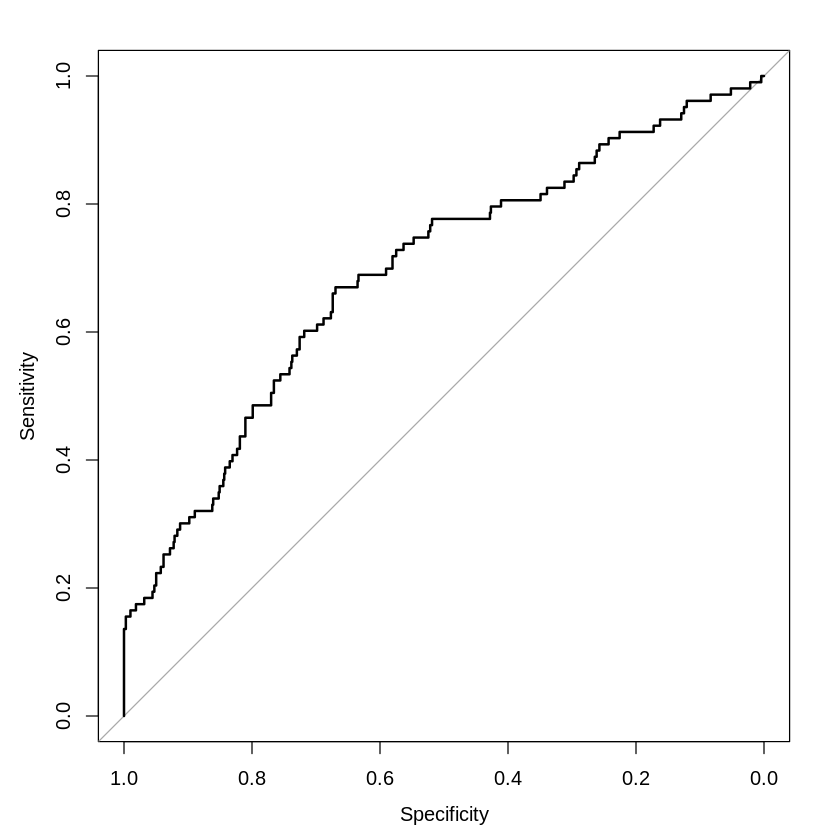

In [ ]:
EvalEN<- predict(elastic_model,newdata=val_set1,type="prob")
roc_obj <- roc(as.factor(val_set1$is_bad),EvalEN[,1] )
auc(roc_obj)
val_p <- ifelse(val_set1$is_bad == "yes",1,0)
LogLoss(EvalEN[,1],val_p)
p_Val <- ifelse(EvalEN[,1] > 0.1, "yes","no")
precision <- posPredValue(factor(p_Val), val_set1$is_bad, positive="yes")
recall <- sensitivity(factor(p_Val), val_set1$is_bad, positive="yes")

F1 <- (2 * precision * recall) / (precision + recall)
print("F1")
print(F1)
print(precision)
print(recall)
plot(roc_obj)
varImp(elastic_model)

In [ ]:
print(elastic_model)

glmnet 

7201 samples
  20 predictor
   2 classes: 'no', 'yes' 

Pre-processing: scaled (68), centered (68) 
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 5761, 5762, 5761, 5760, 5760, 5762, ... 
Resampling results across tuning parameters:

  alpha      lambda        Accuracy   Kappa     
  0.1000000  6.820898e-05  0.8900154  0.24342486
  0.1000000  1.897955e-04  0.8900154  0.24342486
  0.1000000  5.281173e-04  0.8901542  0.24383353
  0.1000000  1.469518e-03  0.8900848  0.24310980
  0.1000000  4.089021e-03  0.8902236  0.24352140
  0.1000000  1.137794e-02  0.8903625  0.24172712
  0.1000000  3.165980e-02  0.8905013  0.24161809
  0.1000000  8.809528e-02  0.8899458  0.23558295
  0.2285714  6.820898e-05  0.8900154  0.24342486
  0.2285714  1.897955e-04  0.8900154  0.24342486
  0.2285714  5.281173e-04  0.8901542  0.24383353
  0.2285714  1.469518e-03  0.8900848  0.24310980
  0.2285714  4.089021e-03  0.8901542  0.24165866
  0.2285714  1.137794e-02  0.8903625 

In [ ]:
print(LogLoss(EvalEN[,1],val_set1$is_bad))

In [ ]:
library(caret)
reKNN <- train(is_bad~.,data=train_set1,
               preProcess = c("center","scale"),
               method = "knn",
               trControl = control,
               tuneLength = 8
)                      

In [ ]:
set.seed(204)
EvalKNN<- predict(reKNN,newdata=val_set1,type="prob")
roc_obj <- roc(as.factor(val_set1$is_bad),EvalKNN[,1] )
auc(roc_obj)

Setting levels: control = no, case = yes

Setting direction: controls > cases



Area under the curve: 0.6011

Setting levels: control = no, case = yes

Setting direction: controls < cases



Area under the curve: 0.5057

Warning message in Ops.factor(y_true, log(y_pred)):
“‘*’ not meaningful for factors”
Warning message in Ops.factor(1, y_true):
“‘-’ not meaningful for factors”


[1] NA

[1] 0.1289507
[1] 0.9902913


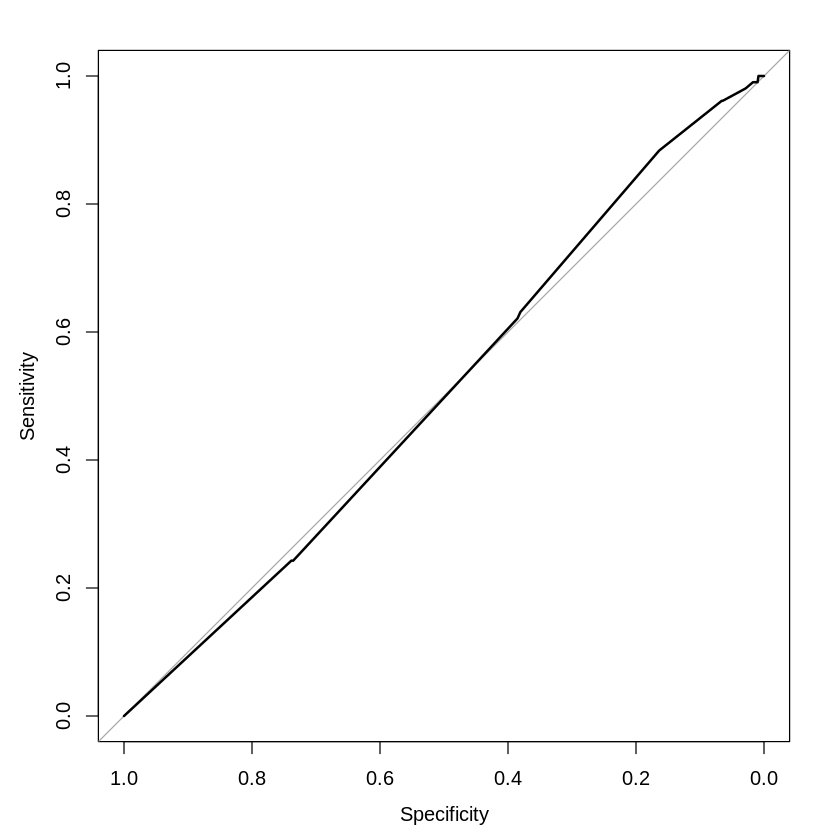

In [ ]:
roc_obj <- roc(as.factor(val_set1$is_bad),EvalKNN[,1] )
auc(roc_obj)
val_n <- ifelse()
LogLoss(EvalKNN[,1],validation$is_bad)
p_Val <- ifelse(EvalKNN[,1] > 0.1, "yes","no")
precision <- posPredValue(factor(p_Val), val_set1$is_bad, positive="yes")
recall <- sensitivity(factor(p_Val), val_set1$is_bad, positive="yes")

F1 <- (2 * precision * recall) / (precision + recall)
print(precision)
print(recall)
plot(roc_obj)

In [ ]:
install.packages("randomForest")
library(randomForest)

+ Fold1.Rep1: mtry= 2 
- Fold1.Rep1: mtry= 2 
+ Fold1.Rep1: mtry=11 
- Fold1.Rep1: mtry=11 
+ Fold1.Rep1: mtry=20 
- Fold1.Rep1: mtry=20 
+ Fold1.Rep1: mtry=30 
- Fold1.Rep1: mtry=30 
+ Fold1.Rep1: mtry=39 
- Fold1.Rep1: mtry=39 
+ Fold1.Rep1: mtry=49 
- Fold1.Rep1: mtry=49 
+ Fold1.Rep1: mtry=58 
- Fold1.Rep1: mtry=58 
+ Fold1.Rep1: mtry=68 
- Fold1.Rep1: mtry=68 
+ Fold2.Rep1: mtry= 2 
- Fold2.Rep1: mtry= 2 
+ Fold2.Rep1: mtry=11 
- Fold2.Rep1: mtry=11 
+ Fold2.Rep1: mtry=20 
- Fold2.Rep1: mtry=20 
+ Fold2.Rep1: mtry=30 
- Fold2.Rep1: mtry=30 
+ Fold2.Rep1: mtry=39 
- Fold2.Rep1: mtry=39 
+ Fold2.Rep1: mtry=49 
- Fold2.Rep1: mtry=49 
+ Fold2.Rep1: mtry=58 
- Fold2.Rep1: mtry=58 
+ Fold2.Rep1: mtry=68 
- Fold2.Rep1: mtry=68 
+ Fold3.Rep1: mtry= 2 
- Fold3.Rep1: mtry= 2 
+ Fold3.Rep1: mtry=11 
- Fold3.Rep1: mtry=11 
+ Fold3.Rep1: mtry=20 
- Fold3.Rep1: mtry=20 
+ Fold3.Rep1: mtry=30 
- Fold3.Rep1: mtry=30 
+ Fold3.Rep1: mtry=39 
- Fold3.Rep1: mtry=39 
+ Fold3.Rep1: mtry=49 
- Fold3.Rep

Setting levels: control = no, case = yes

Setting direction: controls > cases



Area under the curve: 0.6755

Warning message in Ops.factor(y_true, log(y_pred)):
“‘*’ not meaningful for factors”
Warning message in Ops.factor(1, y_true):
“‘-’ not meaningful for factors”


[1] NA

[1] 0.1133758
[1] 0.8640777


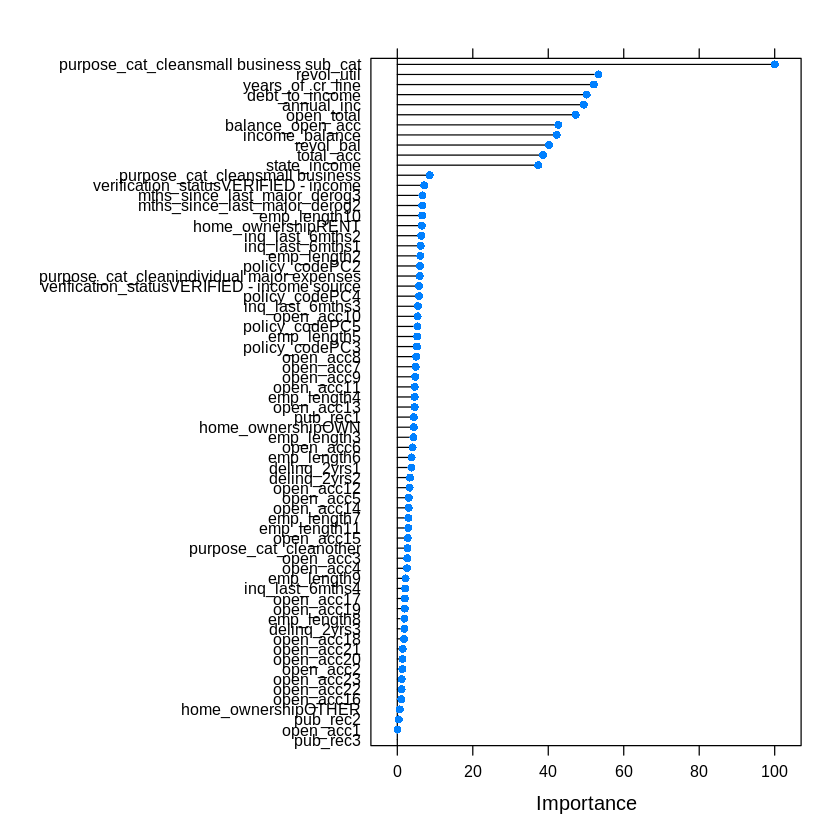

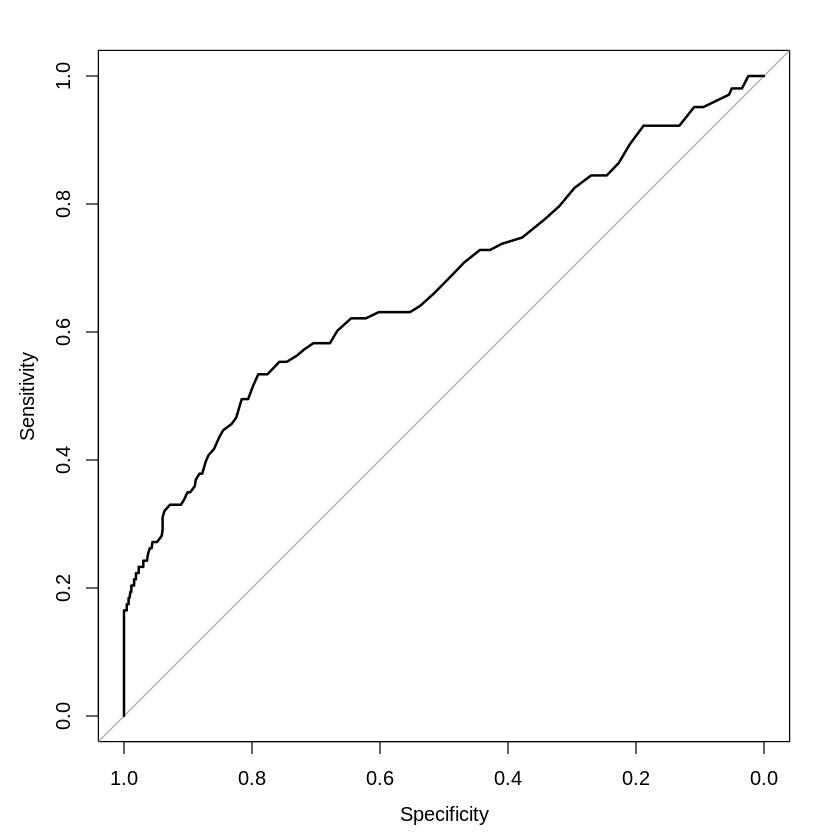

In [ ]:
reRF <- train(is_bad~.,data=train_set1,
               method = "rf",
               ntree = 250,
               trControl = control,
               tuneLength = 8
)
plot(varImp(reRF))
EvalRF <- predict(reRF,newdata=val_set1,type="prob")
roc_obj <- roc(as.factor(val_set1$is_bad),EvalRF[,1] )
auc(roc_obj)
LogLoss(EvalRF[,1],val_set$is_bad)
p_Val <- ifelse(EvalRF[,1] > 0.1, "yes","no")
precision <- posPredValue(factor(p_Val), val_set1$is_bad, positive="yes")
recall <- sensitivity(factor(p_Val), val_set1$is_bad, positive="yes")

F1 <- (2 * precision * recall) / (precision + recall)
print(precision)
print(recall)
plot(roc_obj)

Setting levels: control = no, case = yes

Setting direction: controls > cases



Area under the curve: 0.6755

[1] 0.7061023
[1] 0.1133758
[1] 0.8640777


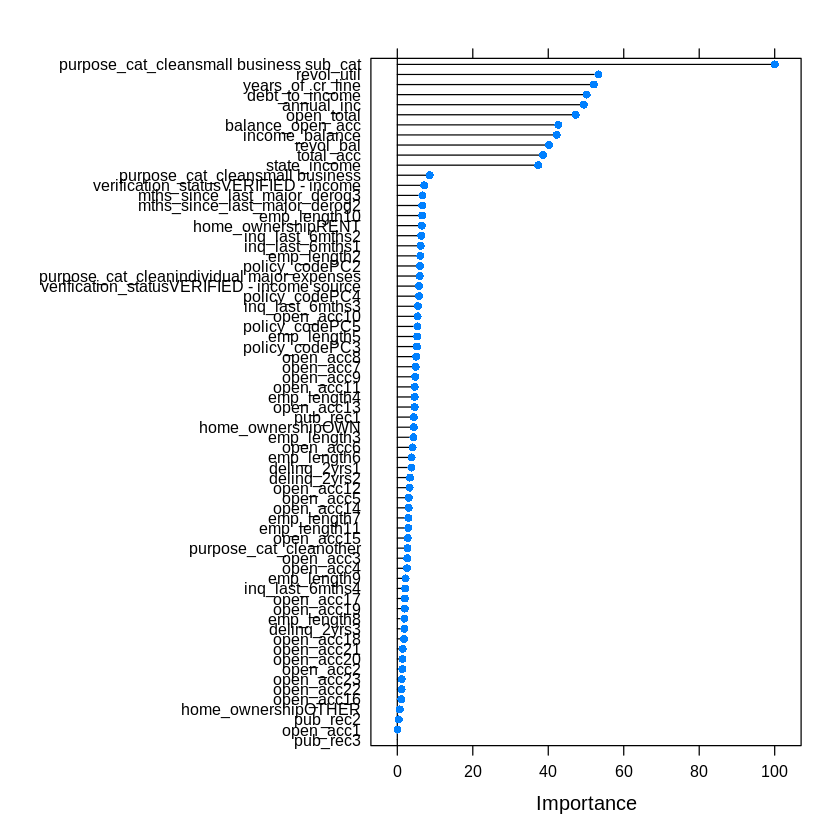

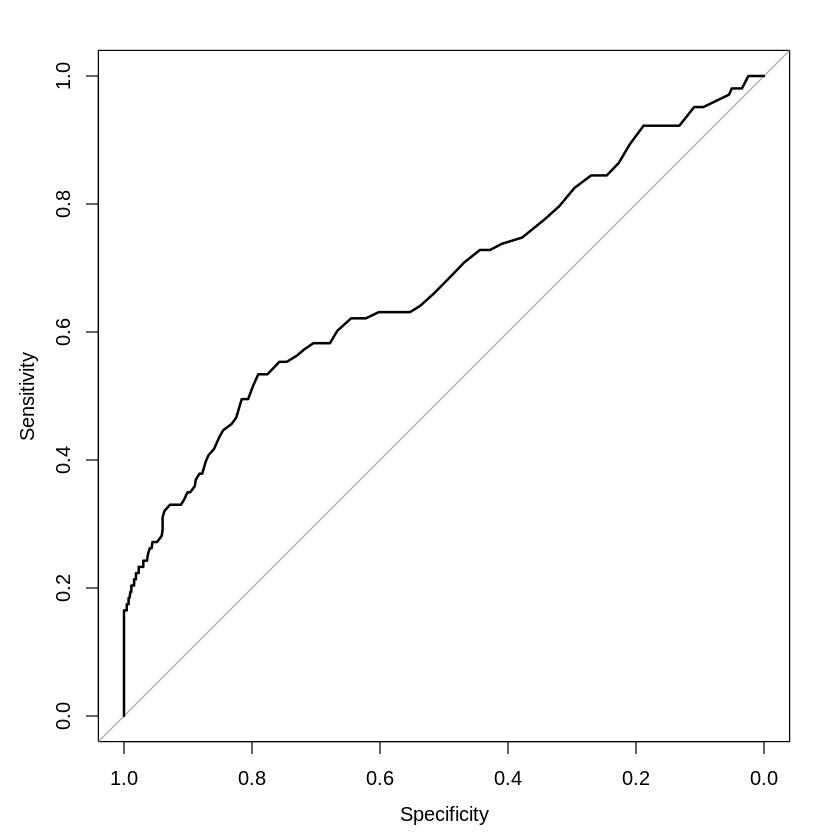

In [ ]:
plot(varImp(reRF))
EvalRF <- predict(reRF,newdata=val_set1,type="prob")
roc_obj <- roc(as.factor(val_set1$is_bad),EvalRF[,1] )
auc(roc_obj)
ref_logloss <- LogLoss(as.numeric(EvalRF[,1]),as.numeric(val_set1$is_bad))
print(ref_logloss)
p_Val <- ifelse(EvalRF[,1] > 0.1, "yes","no")
precision <- posPredValue(factor(p_Val), val_set1$is_bad, positive="yes")
recall <- sensitivity(factor(p_Val), val_set1$is_bad, positive="yes")

F1 <- (2 * precision * recall) / (precision + recall)
print(precision)
print(recall)
plot(roc_obj)

In [ ]:
save(reRF,reKNN,elastic_model,file= "models.RData")

In [ ]:
install.packages("xgboost")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(xgboost)
train_mat <- data.matrix(train_set0)
train_d <- train_mat[,-1]
train_label <- train_mat[,1]
train_label <- train_label - 1 
dtrain <- xgb.DMatrix(data = train_d, label= train_label)
test_mat = data.matrix(val_set0)
test_d <- test_mat[,-1]
test_label <-test_mat[,1]
test_label <- test_label -1 
dtest <- xgb.DMatrix(data = test_d, label= test_label)
negative_cases <- sum(train_label == FALSE)
postive_cases <- sum(train_label == TRUE)
model <- xgboost(data = dtrain, # the data 
                 max.depth = 6,
                 nround = 250,  
                 max_leaves = 90,
                 early_stopping_rounds = 30,
                 eval.metric = "logloss",
                 eta = 0.2,
                 #weight = 5,
                 #lambda = 10,
                 objective = "binary:logistic" ,
                 scale_pos_weight = negative_cases/postive_cases,
                 gamma = 1,
) 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6436

[1] 0.4143861

[1] 0.1911765
[1] 0.5048544


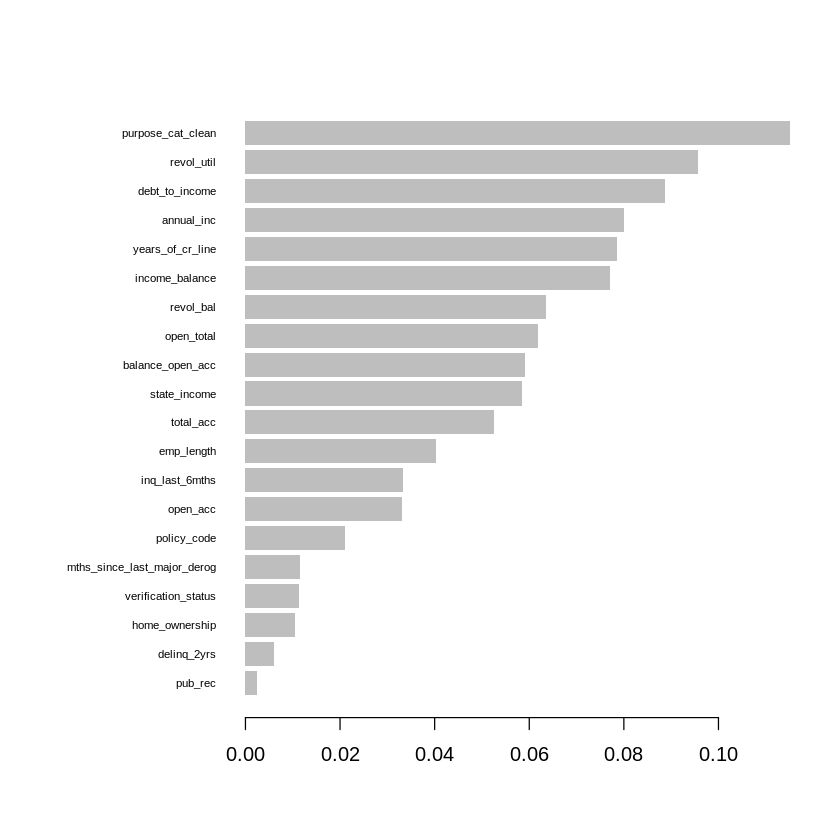

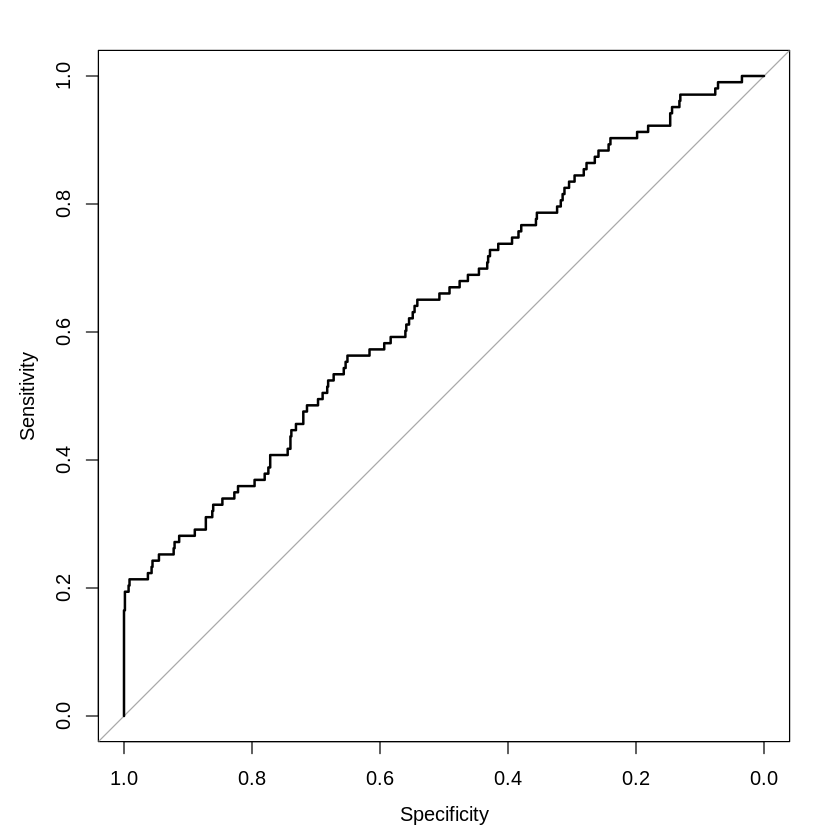

In [ ]:
importance_matrix <- xgb.importance(names(train_mat), model = model)
xgb.plot.importance(importance_matrix)
pred <- predict(model, dtest)
roc_obj <- roc(as.factor(test_label),pred)
auc(roc_obj)
LogLoss(pred,test_label)
p_Val <- ifelse(pred > 0.1, 1,0)
precision <- posPredValue(factor(p_Val), factor(test_label), positive="1")
recall <- sensitivity(factor(p_Val), factor(test_label), positive="1")

F1 <- (2 * precision * recall) / (precision + recall)
print(precision)
print(recall)
plot(roc_obj)

In [ ]:
str(test_label)

 num [1:799] 0 0 0 1 0 1 0 0 0 0 ...


In [ ]:
install.packages("gbm")
library(gbm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loaded gbm 2.1.8.1



In [ ]:
train_set0$is_bad[1:5]

[1] 0 0 0 0 0
Levels: 0 1

In [ ]:
grid <- expand.grid(n.trees = c(100,200), interaction.depth=c(1:3), shrinkage=c(0.05,0.1), n.minobsinnode=c(20))
unwantedoutput <- capture.output(GBMModel <- train(is_bad~purpose_cat_clean+annual_inc+open_total+
  revol_util+years_of_cr_line+total_acc+state_income+income_balance+ balance_open_acc+
  revol_balance+ det_to_income
  

,data = train_set1,
                  method = "gbm", trControl = control, tuneGrid = grid))



In [ ]:
print(GBMModel)

Stochastic Gradient Boosting 

7201 samples
   9 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 5762, 5760, 5760, 5761, 5761, 5760, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.05       1                  100      0.8898767  0.2345858
  0.05       1                  200      0.8899460  0.2364185
  0.05       2                  100      0.8901544  0.2386867
  0.05       2                  200      0.8907795  0.2480220
  0.05       3                  100      0.8909184  0.2475457
  0.05       3                  200      0.8914737  0.2617631
  0.10       1                  100      0.8899460  0.2358608
  0.10       1                  200      0.8902933  0.2412696
  0.10       2                  100      0.8905015  0.2446015
  0.10       2                  200      0.8907795  0.2584583
  0.10       3                  100      0.89

In [ ]:
pred <- predict(GBMModel, val_set1,type="prob")


Setting levels: control = no, case = yes

Setting direction: controls > cases



Area under the curve: 0.6534

[1] 2.078807

[1] "F1"
[1] 0.2004505
[1] 0.1133758
[1] 0.8640777


gbm variable importance

                                           Overall
purpose_cat_cleansmall business sub_cat    100.000
annual_inc                                  16.509
revol_util                                  14.878
total_acc                                   13.038
open_total                                  12.614
years_of_cr_line                            11.241
purpose_cat_cleansmall business             10.577
income_balance                               8.946
balance_open_acc                             7.930
state_income                                 7.402
purpose_cat_cleanother                       1.002
purpose_cat_cleanindividual major expenses   0.000

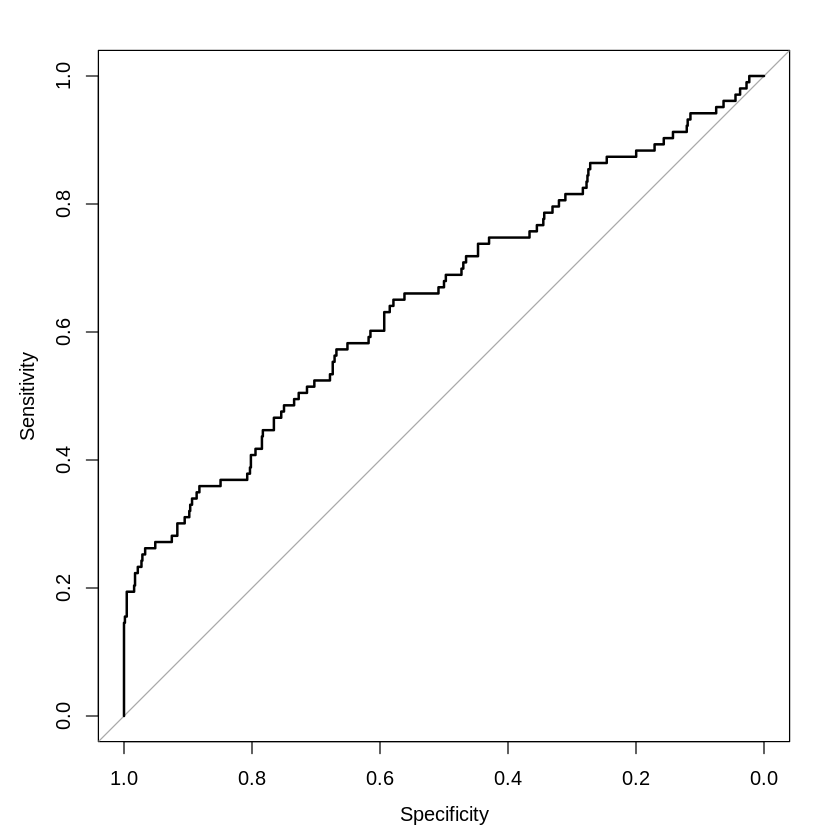

In [ ]:
roc_obj <- roc(as.factor(val_set1$is_bad),pred[,1])
auc(roc_obj)
val_c <- ifelse(val_set1$is_bad == "no",0,1)
LogLoss(pred[,1],val_c)
p_Val <- ifelse(pred[,1] > 0.09, 1,0)
precision <- posPredValue(factor(p_Val), factor(test_label), positive="1")
recall <- sensitivity(factor(p_Val), factor(test_label), positive="1")

F1 <- (2 * precision * recall) / (precision + recall)
print("F1")
print(F1)
print(precision)
print(recall)
plot(roc_obj)
varImp(GBMModel)